In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)


48

# Preparations

In [2]:
# # Need to run these scripts once in the beginning to prepare all ingredients for the analysis
# # - this might take several minutes, so run these only if you haven't done so before.

# # load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py
# %run ../../core/event_numbers.py

# # calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# # run these every time there are updates to resolution, binning, or mephistograms
# # load and prepare the energy and angular resolutions
# %run ../../core/resolution.py --renew_calc
# #--renew_calc if you want to repeat the resolution generation (takes a few minutes)

# # gather all ingredients and save them as unified 'mephistogram' data structure
# %run ../../core/prepare_histograms.py

# Imports

In [3]:
import pickle
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import astro_flux, atmo_background
import mephisto
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import (
    LOCALPATH,
    BASEPATH,
    sigma3,
    sigma5,
    PHI_NGC,
    GAMMA_NGC,
    E0_NGC,
    LIVETIME,
)
import settings as st
from likelihood import setup_multi_llh, ps_llh_multi
from tools import (
    array_source_interp,
    get_scaler,
    scaling_estimation,
)
from tqdm import tqdm

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!


In [4]:
# print TS significance levels
from settings import sigma3
from scipy.stats import chi2

print(f"{sigma3:1.3e}")
print(sigma5, sigma3)
print(chi2.sf(11.6, 1))
print(chi2.isf(0.05, 1))

6.749e-04
1.433257859617676e-07 0.0006749490158150517
0.0006595181936910385
3.8414588206941285


In [5]:
with open("../../local/txs_contour.pkl", "rb") as f:
    txs_contour = pickle.load(f)

# Settings

In [6]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [7]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

In [8]:
from matplotlib.colors import LogNorm

# Atmospheric background


In [9]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [10]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (501, 140);
False


In [11]:
# save for plotting script
with open(join(st.BASEPATH, "resources/baseline_energy_res_upgoing.pckl"), "wb") as f:
    pickle.dump((baseline_eres.histo, baseline_eres.bins), f)

with open(join(st.BASEPATH, "resources/improved_energy_res_upgoing.pckl"), "wb") as f:
    pickle.dump((improved_eres.histo, improved_eres.bins), f)

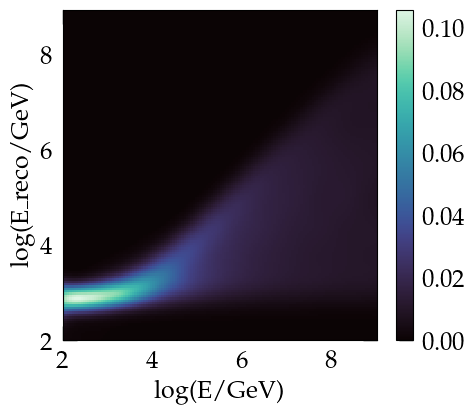

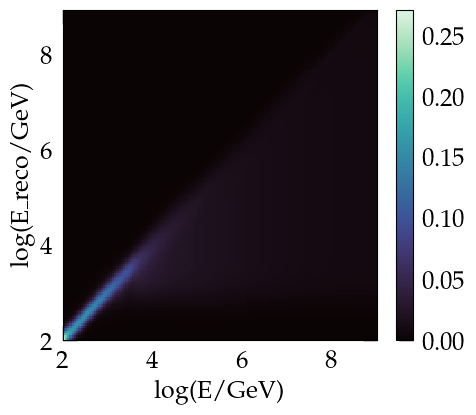

In [12]:
# full range, easy plotting
baseline_eres.plot()
improved_eres.plot()

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [13]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

if False:
    with open(join(st.BASEPATH, "resources/energy_psi.pckl"), "wb") as f:
        pickle.dump((e_psi2_grid.histo, (e_psi2_grid.bins)), f)

Text(0.5, 0, '$\\Psi^2 = |\\Omega_{\\rm true} - \\Omega_{\\rm reco}|^2$')

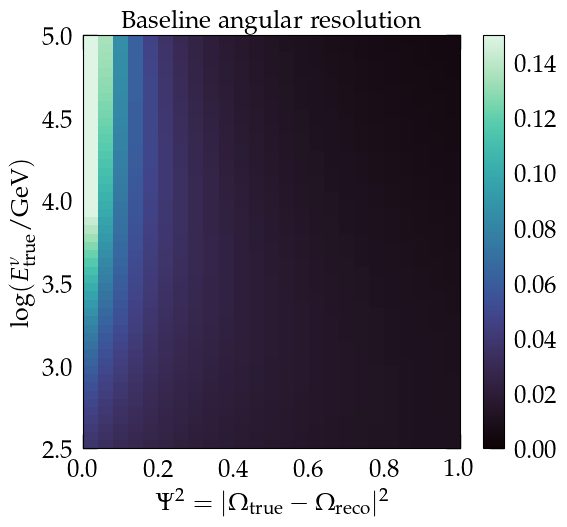

In [14]:

f, ax = plt.subplots(figsize=(6, 5))
ax.set_title("Baseline angular resolution")
f, ax = mephisto.plot_mephistogram(
    e_psi2_grid,
    f=f,
    ax=ax,  vmin=0, vmax=0.15,
    linewidth=0,
    rasterized=True, #norm=LogNorm()
)
ax.set_ylim(2.5, 5)
ax.set_xlim(0, 1)
ax.set_ylabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
ax.set_xlabel(r"$\Psi^2 = |\Omega_{\rm true} - \Omega_{\rm reco}|^2$")

# NGC1068 and TXS 0506 source parameters

In [15]:
from fluxes import ngc_flux, ngc_cut_flux, txs_flux

In [16]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)


In [17]:
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)


In [18]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = st.txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = st.txs0506.dec.rad

_source = {
    "ngc": {"src_config": ngc_src_config, "bg_config": ngc_bg_config, "flux": ngc_flux},
    "txs": {"src_config": txs_src_config, "bg_config": txs_bg_config, "flux": txs_flux},
}

## Check event numbers

In [19]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))
bckg_flux = array_source_interp(
    ngc_bg_config["dec"],
    bckg_histo[ident],
    bckg_histo[ident].bin_mids[0],
    axis=1,
)
k_b = atmo_background(
    aeff_factor_bckg,
    bckg_flux,
    baseline_eres,
)
print("Bckg:", np.sum(k_b))

ngc 1068: 98.2082534964597
Bckg: 1488.281037312281


txs 0506+056: 5.581804873019876


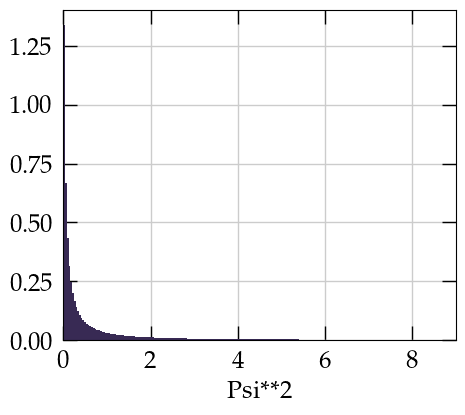

In [20]:

aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))

k_s.sum(axis=1, return_mephisto=True).plot()
#plt.gca().set_yscale("log")

# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know

--> Imported from likelihood.py


# Disc. potential vs livetime

In [111]:
# standard
thresholds = [sigma5]
livetimes = np.logspace(-0.5, 1.5, num=15)

for src_key in _source:
    print(src_key)

    tmp = []  # save output here
    for lt, dec in product(livetimes, np.deg2rad([0, 20, 40, 60, 80])):
        # set livetime relative to 10 years here
        conf = (["IceCube"], [lt])

        # choose the configs per source
        cur_bg_conf = ngc_bg_config.copy() if src_key == "ngc" else txs_bg_config.copy()
        cur_bg_conf["dec"] = dec
        cur_sig_conf = (
            ngc_src_config.copy() if src_key == "ngc" else txs_src_config.copy()
        )
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=_source[src_key]["flux"],  # select source flux
        )
        if np.isclose(np.sum(all_k_s), 0):
            continue
        # calculate an estimate for the flux scaling
        scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the 5-sigma discovery threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                shape="powerlaw",
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=_source[src_key]["flux"].E0,
                phi_0=_source[src_key]["flux"].norm,
            )
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_multi(x, **dct)

            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, _source[src_key]["flux"].gamma),
                approx_grad=True,
            )
            pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
            tmp_dct = {
                "ident": ident,
                "livetime": lt,  # relative to 10 years
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_b": np.sum(all_k_b),
                "n_sig": np.sum(current_k_s),
                "pval": pval,
                "log10(p)": -np.log10(pval),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.livetime == lt)
                & (tmp_df.ident == ident)
                & (tmp_df.dec == dec)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

    df = pd.DataFrame(tmp)
    df.to_pickle(join(LOCALPATH, f"{src_key}_disc_pot_vs_livetime.pickle"))

ngc
txs


In [ ]:
scaling = []
for src_key in _source:

    df = pd.read_pickle(join(LOCALPATH, f"{src_key}_disc_pot_vs_livetime.pickle"))
    flux = pd.DataFrame(
        df.groupby(["ident", "livetime", "dec"]).apply(lambda x: get_scaler(x, sigma5))
        * _source[src_key]["flux"].norm,
        columns=["disc5"],
    ).reset_index()

    print(src_key)
    ## fit the DP vs lifetime scaling as a powerlaw, and extract the index
    _scaling = flux.groupby("dec").apply(lambda x: np.polyfit(np.log10(x.livetime), np.log10(x.disc5), deg=1)[0])
    print(_scaling)
    _scaling = pd.DataFrame(_scaling, columns=["scaling_index"])
    _scaling["src"] = src_key
    scaling.append(_scaling)

    print()

scaling = pd.concat(scaling).reset_index()

ngc
dec
0.000000   -0.547793
0.349066   -0.555990
0.698132   -0.564498
1.047198   -0.566576
1.396263   -0.567505
dtype: float64

txs
dec
0.000000   -0.760948
0.349066   -0.715731
0.698132   -0.698372
1.047198   -0.684613
1.396263   -0.675289
dtype: float64



## plotting

,count,mean,std,min,25%,50%,75%,max
src,,,,,,,,
ngc,5.0,-0.560472,0.008423,-0.567505,-0.566576,-0.564498,-0.555990,-0.547793
txs,5.0,-0.706991,0.033793,-0.760948,-0.715731,-0.698372,-0.684613,-0.675289


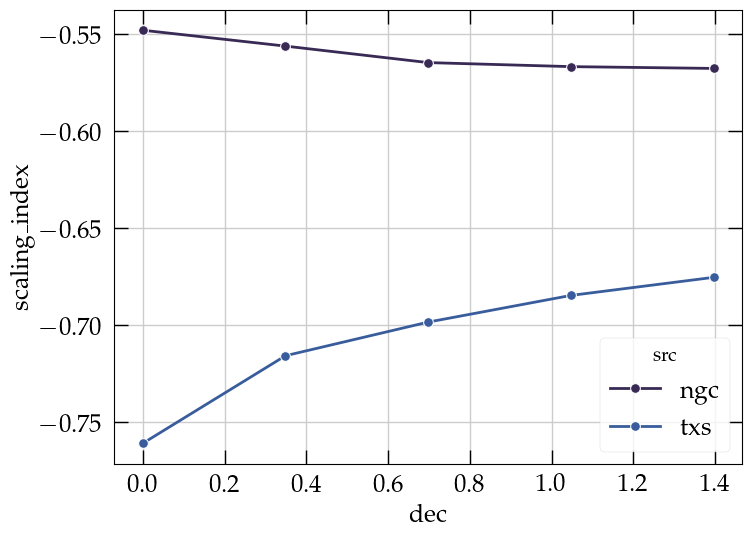

In [120]:
sns.lineplot(data=scaling, x="dec", y="scaling_index", hue="src", marker="o")
scaling.groupby("src").scaling_index.describe()

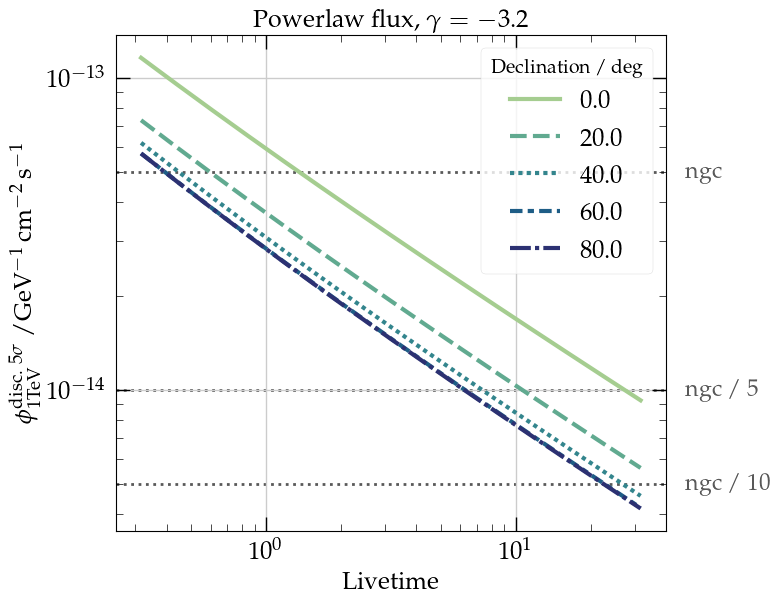

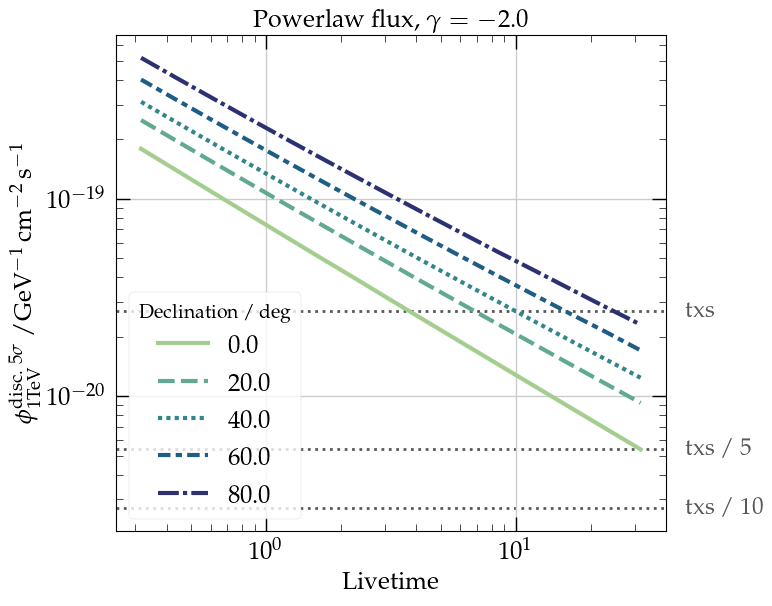

In [115]:
for src_key in _source:

    df = pd.read_pickle(join(LOCALPATH, f"{src_key}_disc_pot_vs_livetime.pickle"))
    flux = pd.DataFrame(
        df.groupby(["ident", "livetime", "dec"]).apply(lambda x: get_scaler(x, sigma5))
        * _source[src_key]["flux"].norm,
        columns=["disc5"],
    ).reset_index()

    f, ax = plt.subplots(figsize=(7, 6))
    flux["dec_deg"] = np.round(np.rad2deg(flux.dec))
    sns.lineplot(
        flux, x="livetime", y="disc5", hue="dec_deg", style="dec_deg", palette="crest", lw=3
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"Livetime")
    ax.set_ylabel(
        r"$\phi^{\mathrm{disc.}~5\sigma }_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
    )
    ax.legend(title="Declination / deg")
    font_color = "0.35"
    for ii in [1, 5, 10]:
        ax.axhline(
            _source[src_key]["flux"].norm / ii, ls=":", lw=2, color=font_color, zorder=0
        )
        ax.text(
            x=np.max(flux.livetime) * 1.5,
            y=_source[src_key]["flux"].norm / ii,
            va="center",
            s=src_key if ii == 1 else f"{src_key} / {ii}",
            color=font_color,
            fontsize="large",
            ha="left",
        )

    ax.set_title(rf"Powerlaw flux, $\gamma=-{_source[src_key]['flux'].gamma}$")

    # see plotting_standalone.ipynb for final version